In [5]:
import pandas as pd
import ast

In [6]:
def upload_dataset():
    df = pd.read_csv("../data/movies_metadata_cleaned_v1.csv", index_col=0)
    required_columns = [
        "id",
        "imdb_id",
        "title",
        "genres",
        "original_title",
        "overview",
        "cast",
        "poster_path",
        "director",
    ]
    df = df[required_columns]

    df["combined_rows"] = df.apply(
        lambda x: f"The movie {x['title']} is directed by {x['director']} and has the following genres ({', '.join(ast.literal_eval(x['genres']))}) and the cast includes ({', '.join(ast.literal_eval(x['cast']))}) and the overview is {x['overview']}",
        axis=1,
    )
    return df

In [9]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [10]:
import requests

df = upload_dataset()

OMDP_API_KEY = os.getenv("OMDP_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")


def get_poster(imdb_id: int, omdp_api_key: str = OMDP_API_KEY):
    url = f"http://www.omdbapi.com/?apikey={omdp_api_key}&i={imdb_id}"
    response = requests.get(url)
    data = response.json()
    print(data)
    return data

In [11]:
from qdrant_client import QdrantClient, models

In [12]:
client = QdrantClient(
    url=QDRANT_URL,
    api_key=os.getenv("QDRANT_API_KEY"),
)

client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='movies_metadata')])

In [ ]:
combined_rows_list = df["combined_rows"].to_list()

In [14]:
from llama_index.embeddings.openai import OpenAIEmbedding

In [15]:
embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=OPENAI_API_KEY)

In [ ]:
with open("embedded_combined_rows.txt", "r") as f:
    embedded_combined_rows = f.read()

In [ ]:
import json

embedded_combined_rows_list = json.loads(embedded_combined_rows)

In [ ]:
client.upload_points(
    collection_name="movies_metadata",
    points=[
        models.PointStruct(
            id=movies_df["id"],
            vector=embedded_combined_rows_list[idx],
        )
        for idx, movies_df in df.iterrows()
    ],
)

In [26]:
query = embed_model.get_text_embedding(
    "a movie where the most valuable thing is time, its their age and their money"
)

In [27]:
res = client.search(
    collection_name="movies_metadata",
    query_vector=query,
    limit=3,
)

In [28]:
res

[ScoredPoint(id=49530, version=302, score=0.5484225, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=65066, version=133, score=0.48280865, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=274266, version=651, score=0.48048833, payload={}, vector=None, shard_key=None)]

In [29]:
from IPython.display import Image, display

-----------------------------------
In Time
In the not-too-distant future the aging gene has been switched off. To avoid overpopulation, time has become the currency and the way people pay for luxuries and necessities. The rich can live forever, while the rest try to negotiate for their immortality. A poor young man who comes into a fortune of time, though too late to help his mother from dying. He ends up on the run from a corrupt police force known as 'time keepers'.
imdb_id is: tt1637688
{'Title': 'In Time', 'Year': '2011', 'Rated': 'PG-13', 'Released': '28 Oct 2011', 'Runtime': '109 min', 'Genre': 'Action, Sci-Fi, Thriller', 'Director': 'Andrew Niccol', 'Writer': 'Andrew Niccol', 'Actors': 'Justin Timberlake, Amanda Seyfried, Cillian Murphy', 'Plot': 'In a future where people stop aging at 25, but are engineered to live only one more year, having the means to buy your way out of the situation is a shot at immortal youth. Here, Will Salas finds himself accused of murder and on t...'

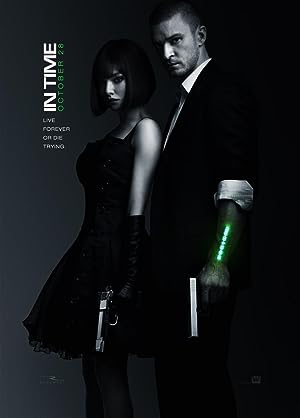

-----------------------------------
Going in Style
Three senior citizens in their 70s who live together are slowly decaying in endless days with nothing to do but feed the birds. One of them comes up with an idea - rob a bank. They certainly could use the money if they get away with it and if they are caught, what could happen to three old men?
imdb_id is: tt0079219
{'Title': 'Going in Style', 'Year': '1979', 'Rated': 'PG', 'Released': '25 Dec 1979', 'Runtime': '97 min', 'Genre': 'Comedy, Crime, Drama', 'Director': 'Martin Brest', 'Writer': 'Edward Cannon, Martin Brest', 'Actors': 'George Burns, Art Carney, Lee Strasberg', 'Plot': 'Three friends living on the dole decide to rob a bank.', 'Language': 'English', 'Country': 'United States', 'Awards': '1 win & 1 nomination', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMmZmY2E1MzYtOWViOS00MWJjLWE2OTUtMDFlNjQ1ZjY0MzQ0L2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyNjUwNzk3NDc@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value':

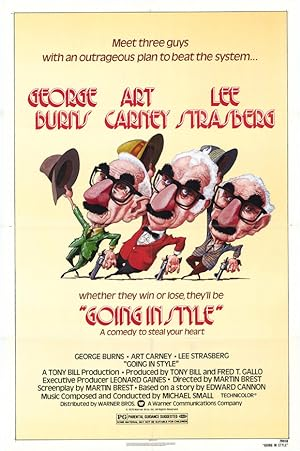

-----------------------------------
Time Again
We have all made mistakes.  Little white lies that blow up in our face, being selfish to a loved one, or just drinking too much the night before.  Its all the same, eventually you wish you had a chance to do it over.  People say they can’t change the past, but what would you say if you were given the chance to make things right?  That is the question presented to a young waitress as she travels back in time, not just once, but three times, to save her older sister from being murdered.  TIME AGAIN takes the audience on a wild sci-fi adventure into the notorious criminal underworld.  After a young waitress receives strange coins for a tip, she inadvertently becomes embroiled in an underworld battle with a notorious criminal that leads to her death.  With the help of a mysterious old lady, the waitress's younger sister goes back in time to save her from being murdered.
imdb_id is: tt1388369
{'Title': 'Time Again', 'Year': '2011', 'Rated': 'N/

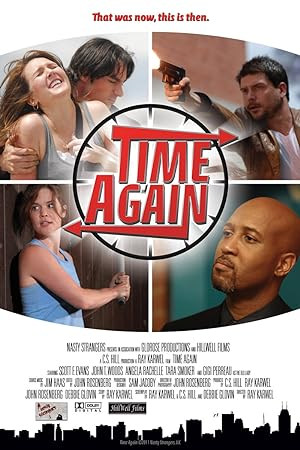

In [30]:
for movies in res:
    dataframe = df[df["id"] == movies.id]
    print("-" * 35)
    print(dataframe["title"].values[0])
    print(dataframe["overview"].values[0])
    print(f'imdb_id is: {dataframe["imdb_id"].values[0]}')
    display(Image(get_poster(dataframe["imdb_id"].values[0])["Poster"]))